In [1]:
import numpy as np
from matplotlib  import pyplot as plt
import os
from pathlib import Path
from keras.preprocessing import image

Using TensorFlow backend.


### Preparing Data

In [2]:
p = Path("Images/")

dir = p.glob("*")

imageData = []
labelsDict = {"cat":0,"dog":1,"horse":2,"human":3}
labels = []

for folderDir in dir:
    label = str(folderDir).split("\\")[-1][:-1]
    print(label)
    for imgPath in folderDir.glob("*.jpg"):
        img = image.load_img(imgPath,target_size=(32,32))
        imgArr = image.img_to_array(img)
        imageData.append(imgArr)
        labels.append(labelsDict[label])

cat
dog
horse
human


In [3]:
labels = np.array(labels)
imageData = np.array(imageData,dtype = "float32")/255.0
print(labels.shape)
print(imageData.shape)

(808,)
(808, 32, 32, 3)


In [4]:
import random

In [5]:
combined = list(zip(imageData,labels))
random.shuffle(combined)

imageData[:],labels[:] = zip(*combined)

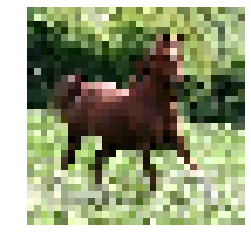

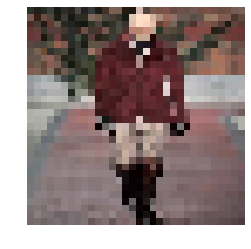

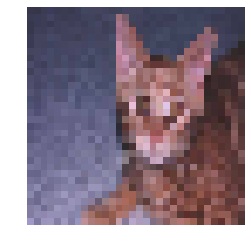

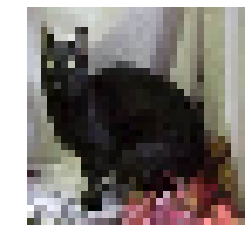

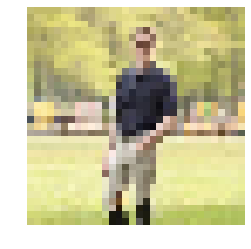

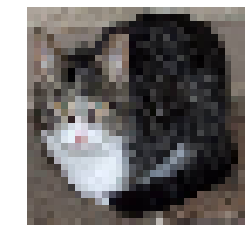

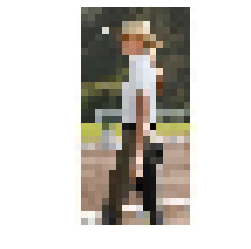

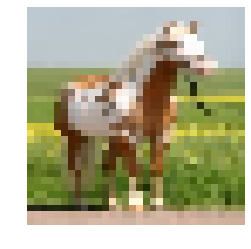

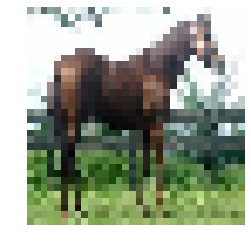

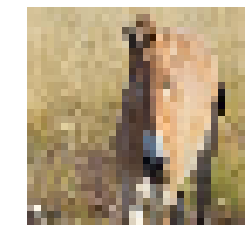

In [6]:
def drawImg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

for i in range(10):
    drawImg(imageData[i])

In [7]:
m = imageData.shape[0]
imageData = imageData.reshape(m,-1)
imageData.shape

(808, 3072)

In [66]:
classes = len(np.unique(labels))
print(classes)

4


In [67]:
class SVM:
    def __init__(self,c = 1.0):
        self.c = c
        self.w = 0
        self.b = 0
    def hingeLoss(self,w,b,x,y):
        loss = 0.0
        
        loss += 0.5*np.dot(w,w.T)
        m = x.shape[0]
        
        for i in range(m):
            ti = y[i]*(np.dot(w,x[i].T)+b)
            loss += self.c*(max(0,(1-ti)))
            
        return loss[0][0]
    
    def fit(self,x,y,batchSize=50,learningRate=0.001,maxItr=500):
        nSamples = x.shape[0]
        nFeatures = x.shape[1]
        
        n = learningRate
        c = self.c
        
        w = np.zeros((1,nFeatures))
        bias = 0
        
        losses = []
        
        for i in range(maxItr):
            l = self.hingeLoss(w,bias,x,y)
            losses.append(l)
            ids = np.arange(nSamples)
            np.random.shuffle(ids)
            
            for batchStart in range(0,nSamples,batchSize):
                gradW = 0
                gradB = 0
                
                for j in range(batchStart,batchStart + batchSize):
                    if j < nSamples:
                        i = ids[j]
                        ti = y[i]*(np.dot(w,x[i].T)+bias)
                        
                        if ti>1:
                            gradW += 0
                            gradB += 0
                        else:
                            gradW += c*y[i]*x[i]
                            gradB = c*y[i]
                w = w - n*w + n*gradW
                bias = bias + n*gradB
            
        self.w = w
        self.b = bias
        return w,bias,losses       

In [68]:
def classWiseData(x,y):
    data = {}
    
    for i in range(classes):
        data[i] = []
    
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [69]:
data = classWiseData(imageData,labels)
data[0].shape

(202, 3072)

In [70]:
def getDataPair(d1,d2):
    l1,l2 = d1.shape[0],d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    dataPair = np.zeros((samples,features))
    dataLabels = np.zeros((samples,))
    
    dataPair[:l1,:] = d1
    dataPair[l1:,:] = d2
    
    dataLabels[:l1] = -1
    dataLabels[l1:] = 1
    
    return dataPair,dataLabels

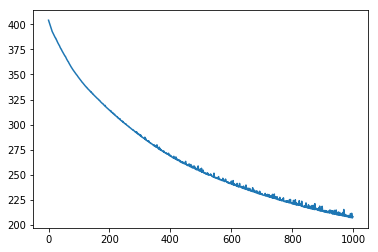

In [71]:
mySVM = SVM()
xPair,yPair = getDataPair(data[0],data[1])
w,b,loss = mySVM.fit(xPair,yPair,learningRate = 0.00001,maxItr = 1000)
plt.plot(loss)
plt.show()

In [72]:
def trainSVM(x,y):
    svmClassifiers= {}
    
    for i in range(classes):
        svmClassifiers[i] = {}
        for j in range(i+1,classes):
            xP,yP = getDataPair(data[i],data[j])
            wts,b,loss = mySVM.fit(xP,yP,learningRate = 0.00001,maxItr = 1000)
            svmClassifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svmClassifiers

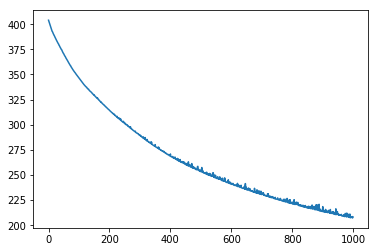

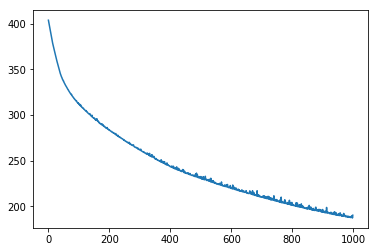

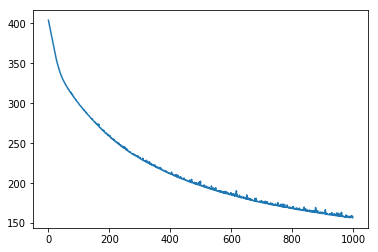

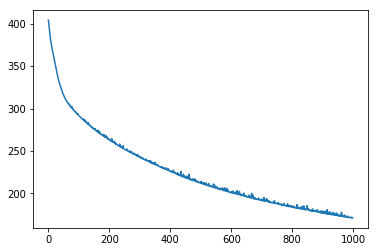

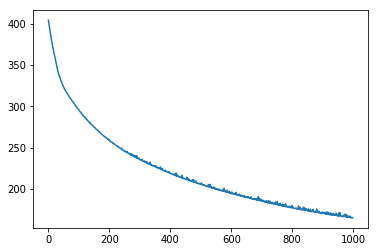

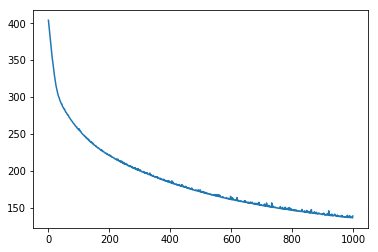

In [73]:
svmClassifiers = trainSVM(imageData,labels)

In [74]:
catsDogs = svmClassifiers[0][1]
catsHumans = svmClassifiers[0][3]
print(catsDogs[0].shape)
print(catsDogs[1])

(1, 3072)
0.0009400000000000018


### Prediction & Accuracy

In [75]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T)+b
    if z >= 0:
        return 1
    else:
        return -1


In [76]:
def predict(x):
    count = np.zeros((classes,))
    
    for i in range(classes):
        for j in range(i+1,classes):
            w,b = svmClassifiers[i][j]
            
            z = binaryPredict(x,w,b)
            
            if z == 1:
                count[j] += 1
            else:
                count[i] += 1
                
    finalPred = np.argmax(count)
    return finalPred
            

In [77]:
print(predict(imageData[0]))
print(labels[0])

2
2


In [85]:
def accuracy(x,y):
    count = 0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if prediction == y[i]:
            count += 1
            
    return count/x.shape[0]

In [86]:
acc = accuracy(imageData,labels)
print(acc)

0.6113861386138614


### Using Sckit

In [81]:
from sklearn import svm

In [83]:
svmClassifier = svm.SVC(kernel = 'linear',C=1.0)

In [84]:
svmClassifier.fit(imageData,labels)
svmClassifier.score(imageData,labels)

0.650990099009901